Overview: Result
================

In this example, we'll repeat the fit performed in `fit.py` of 1D data of a `Gaussian` + Exponential profile with 1D line
data using the  non-linear  search emcee and inspect the *Result* object that is returned in detail.

If you haven't already, you should checkout the notebook `overview/fit.ipynb` to see how the fit is performed by the
code below. The first section of code below is simply repeating the commands in
`overview/fit.ipynb`, so feel free to skip over it until you his the `Result`'s section.

The attributes of the Result object are described in `overview/simple/result.ipynb`. This example will not cover the
attributes in full, and instead only focus on how the use of a more complex model changes the Result object.

In [1]:
%matplotlib inline

import autofit as af

from os import path
import matplotlib.pyplot as plt
import numpy as np

At the top of every tutorial notebook, you'll see the following cell. This cell uses the project `pyprojroot` to
locate the path to the workspace on your computer and use it to set the working directory of the notebook.

In [2]:
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

C:\Users\Jammy\Code\PyAuto\autofit_workspace
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\autofit_workspace`


__Data__

First, lets load data of a 1D `Gaussian` + 1D Exponential, by loading it from a .json file in the directory 
`autofit_workspace/dataset/`, which simulates the noisy data we fit (check it out to see how we simulate the 
data).

In [3]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1__exponential_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

__Model + Analysis__

We create the same model and analysis classes use in the example `autofit_workspace/notebooks/overview/complex/fit.ipynb`.

In [4]:
class Gaussian:

    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments
        intensity=0.1,  # <- are the Gaussian`s model parameters.
        sigma=0.01,
    ):
        """Represents a 1D `Gaussian` profile, which may be treated as a model-component of PyAutoFit the
        parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        sigma : float
            The sigma value controlling the size of the Gaussian.
        """

        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, using its centre.

        Parameters
        ----------
        values : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.intensity, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )

In [5]:
class Exponential:
    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments are the model
        intensity=0.1,  # <- parameters of the Exponential.
        rate=0.01,
    ):
        """Represents a 1D Exponential profile symmetric about a centre, which may be treated as a model-component
        of PyAutoFit the parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        ratw : float
            The decay rate controlling has fast the Exponential declines.
        """

        self.centre = centre
        self.intensity = intensity
        self.rate = rate

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Exponential, using its centre.

        Parameters
        ----------
        values : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return self.intensity * np.multiply(
            self.rate, np.exp(-1.0 * self.rate * abs(transformed_xvalues))
        )

In [6]:
class Analysis(af.Analysis):

    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):
        """
        Determine the log likelihood of a fit of multiple profiles to the dataset.

        Parameters
        ----------
        instance : af.CollectionPriorModel
            The model instances of the profiles.

        Returnsn
        -------
        fit : Fit.log_likelihood
            The log likelihood value indicating how well this model fit the dataset.
        """

        xvalues = np.arange(self.data.shape[0])

        model_data = sum(
            [line.profile_from_xvalues(xvalues=xvalues) for line in instance]
        )

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood

In [7]:
model = af.CollectionPriorModel(gaussian=Gaussian, exponential=Exponential)
analysis = Analysis(data=data, noise_map=noise_map)


Returns the non-linear object for emcee and perform the fit.

In [8]:
emcee = af.Emcee(
    path_prefix=path.join("overview", "complex"),
    nwalkers=50,
    nsteps=2000,
    initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
    auto_correlation_check_for_convergence=True,
    auto_correlation_check_size=100,
    auto_correlation_required_length=50,
    auto_correlation_change_threshold=0.01,
    number_of_cores=1,
)

result = emcee.fit(model=model, analysis=analysis)

INFO:root: already completed, skipping non-linear search.


__RESULT__

Here, we'll look in detail at how the information contained in the result changes when we fit a more complex model. If
you are unfamiliar with the result object, first read through `examples/simple/result.py`.

First, we can note that the parameters list of lists now has 6 entries in the parameters column, given the 
dimensionality of the model has increased from N=3 to N=6.

In [9]:
samples = result.samples
print("All Parameters:")
print(samples.parameters)
print("\nSample 10`s sixth parameter value (Exponential -> rate)")
print(samples.parameters[9][5], "\n")

All Parameters:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The vectors containing models have the same meaning as before, but they are also now of size 6 given the increase in
model complexity.

In [10]:
print("Result and Error Vectors:")
print(samples.median_pdf_vector)
print(samples.max_log_likelihood_vector)
print(samples.max_log_posterior_vector)
print(samples.vector_at_upper_sigma(sigma=3.0))
print(samples.vector_at_lower_sigma(sigma=3.0))
print(samples.error_vector_at_upper_sigma(sigma=3.0))
print(samples.error_vector_at_lower_sigma(sigma=3.0), "\n")

Result and Error Vectors:
[49.94644714913798, 26.341203791124563, 9.916350226331438, 50.222476697040925, 39.81827867053955, 0.04813675989379663]
[49.863255031794004, 25.98905181145413, 9.902857257024161, 50.257046396015234, 40.00549959159537, 0.048311642406452575]
[49.863255031794004, 25.98905181145413, 9.902857257024161, 50.257046396015234, 40.00549959159537, 0.048311642406452575]
[51.82519530557767, 83.1588825732119, 21.555200682524145, 50.74972955320037, 42.061841377650694, 0.13641099671630819]
[49.256999227725245, 21.34623472476286, 9.399288744131365, 28.424372997424907, 2.6310147251250817, 0.02481567906299053]
[1.8787481564396913, 56.817678782087334, 11.638850456192706, 0.5272528561594427, 2.2435627071111455, 0.08827423682251156]
[0.6894479214127358, 4.994969066361705, 0.5170614822000736, 21.798103699616018, 37.187263945414465, 0.0233210808308061] 



The parameter names and labels now contain 6 entries, including the Exponential class that was not included in the
simple model example.

In [11]:
print(samples.model.model_component_and_parameter_names)
print(samples.model.parameter_labels)
print("\n")

['gaussian_centre', 'gaussian_intensity', 'gaussian_sigma', 'exponential_centre', 'exponential_intensity', 'exponential_rate']
['x', 'I', 'sigma', 'x', 'I', '\\lambda']




When we return a result as an instance, it provides us with instances of the model using the Python classes used to
compose it. Because our fit uses a CollectionPriorModel (as opposed to a `PriorModel` in the simple example) the instance
returned a dictionary named acoording to the names given to the CollectionPriorModel, which above were `gaussian` and
`exponential`.

In [12]:
max_log_likelihood_instance = samples.max_log_likelihood_instance

print("Max Log Likelihood `Gaussian` Instance:")
print("Centre = ", max_log_likelihood_instance.gaussian.centre)
print("Intensity = ", max_log_likelihood_instance.gaussian.intensity)
print("Sigma = ", max_log_likelihood_instance.gaussian.sigma, "\n")
print("Max Log Likelihood Exponential Instance:")
print("Centre = ", max_log_likelihood_instance.exponential.centre)
print("Intensity = ", max_log_likelihood_instance.exponential.intensity)
print("Sigma = ", max_log_likelihood_instance.exponential.rate, "\n")

Max Log Likelihood `Gaussian` Instance:
Centre =  49.863255031794004
Intensity =  25.98905181145413
Sigma =  9.902857257024161 

Max Log Likelihood Exponential Instance:
Centre =  50.257046396015234
Intensity =  40.00549959159537
Sigma =  0.048311642406452575 



For our example problem of fitting a 1D `Gaussian` + Exponential profile, this makes it straight forward to plot 
the maximum likelihood model:

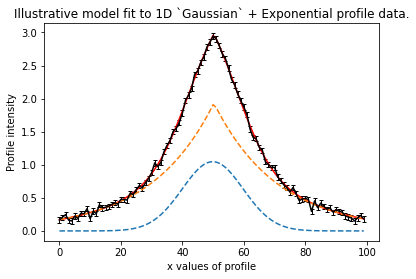

In [13]:
model_gaussian = max_log_likelihood_instance.gaussian.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_exponential = max_log_likelihood_instance.exponential.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = model_gaussian + model_exponential

xvalues = range(data.shape[0])
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), model_gaussian, "--")
plt.plot(range(data.shape[0]), model_exponential, "--")
plt.title("Illustrative model fit to 1D `Gaussian` + Exponential profile data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

All methods which give instances give us the same instance of a CollectionPriorModel:

In [14]:
print(samples.median_pdf_instance)
print(samples.instance_at_upper_sigma)
print(samples.instance_at_lower_sigma)
print(samples.error_instance_at_upper_sigma)
print(samples.error_instance_at_lower_sigma)
print(samples.instance_from_sample_index(sample_index=500))

<bound method PDFSamples.instance_at_upper_sigma of <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x00000207E5A03340>>
<bound method PDFSamples.instance_at_lower_sigma of <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x00000207E5A03340>>
<bound method PDFSamples.error_instance_at_upper_sigma of <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x00000207E5A03340>>
<bound method PDFSamples.error_instance_at_lower_sigma of <autofit.non_linear.mcmc.emcee.EmceeSamples object at 0x00000207E5A03340>>


So that is that - adding model complexity doesn`t change a whole lot about the Result object, other than the switch
to CollectionPriorModels meaning that our instances now have named entries.

The take home point should be that when you name your model components, you should make sure to give them descriptive
and information names that make the use of a result object clear and intuitive!